# Import Libraries & Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display, Markdown
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Load datasets
bioimpedance_df = pd.read_excel('Bioimpedance_Synthetic.xlsx')
health_exam_df = pd.read_excel('Health_Exam_Synthetic.xlsx')
hrv_df = pd.read_excel('HRV_Synthetic.xlsx')


# Step 1: Data Integration & Preprocessing 

In [8]:
# Merge datasets
merged_df = bioimpedance_df.merge(health_exam_df, on='USUBJID').merge(hrv_df, on='USUBJID')

# Calculate AGE
merged_df['AGE'] = pd.to_datetime(merged_df['DVDTC']).dt.year - pd.to_datetime(merged_df['BIRTHDTC']).dt.year

# Drop date columns
merged_df.drop(columns=['BIRTHDTC', 'DVDTC'], inplace=True)

# Encode categorical features
categorical_cols = merged_df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('USUBJID')


from sklearn.preprocessing import LabelEncoder

# Label encode all categorical columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le 


In [ ]:
print(merged_df['SEX'].unique())

male_df = merged_df[merged_df['SEX'] == 0].copy()
female_df = merged_df[merged_df['SEX'] == 1].copy()


[1 0]


In [10]:
#final_df = merged_df
#final_df = male_df
final_df = female_df


final_df = final_df.drop(columns=['SEX'])


In [ ]:
final_df.columns


Index(['USUBJID', 'TBW', 'ICW', 'ECW', 'PROT', 'MINERAL', 'SLM', 'FFM', 'SMM',
       'PBF', 'SLRA–SLLL', 'SWRA–SWLL', 'ICWRA–ICWLL', 'ECWRA–ECWLL', 'ECWR',
       'ECWRRA–ECWRLL', 'FATRA–FATLL', 'BMR', 'ABFR', 'VFA', 'BCM', 'BRMC',
       'BMC', 'BHYDR', 'FFMI', 'FMI', 'CHMC', 'ABDMC', 'RAMC', 'LAMC', 'RLMC',
       'LLMC', 'CHSTFATTHICK', 'ABDMFATTHICK', 'RAFATTHICK', 'LAFATTHICK',
       'RLFATTHICK', 'LLFATTHICK', 'SITEID', 'MSYN', 'HEIGHT', 'WEIGHT', 'BMI',
       'SYSBP', 'DIABP', 'PULSE', 'SMOKECNF', 'ALCOHOLYN', 'MH_HL', 'MH_HTN',
       'MH_DM', 'CM_HL', 'CM_HTN', 'CM_DM', 'cold', 'heat', 'chcat',
       'PSSTOTAL', 'PSQITOTAL', 'CREAT', 'GFRE', 'HGB', 'GLUC', 'AST', 'ALT',
       'GGT', 'WAISTCIR', 'HIPCIR', 'VLF', 'LF', 'HF', 'TP', 'LFNM', 'HFNM',
       'HR', 'HRVINDEX', 'SDNN', 'AGE'],
      dtype='object')

# Step 2: Exploratory Data Analysis (EDA)

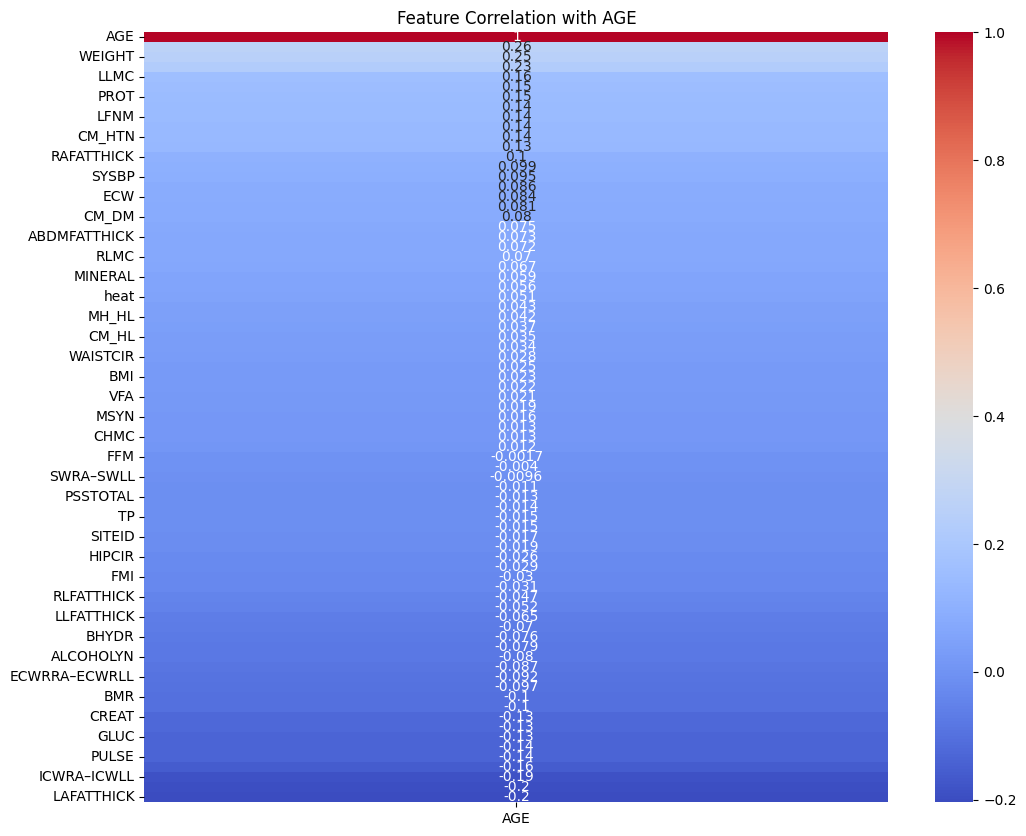

In [ ]:
# Compute correlation matrix only on numeric columns
corr_matrix = final_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['AGE']].sort_values(by='AGE', ascending=False), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with AGE')
plt.show()


# Step 3: Feature Selection (with Dynamic Explanation)

## Feature Description

In [13]:
feature_metadata = {

    # === Bioimpedance Features ===
    'TBW': 'Total Body Water — decreases with aging due to muscle and hydration loss.',
    'ICW': 'Intracellular Water — decreases with aging due to muscle loss.',
    'ECW': 'Extracellular Water — increases with aging due to tissue composition changes.',
    'PROT': 'Protein Mass — reflects nutritional status and lean body mass.',
    'MINERAL': 'Mineral Content — reflects bone density and mineral status, may decline with age.',
    'SLM': 'Soft Lean Mass — lean mass excluding bone, declines with aging.',
    'FFM': 'Fat-Free Mass — protective against frailty, declines with aging.',
    'SMM': 'Skeletal Muscle Mass — declines with aging, marker of sarcopenia.',
    'PBF': 'Percent Body Fat — increases with aging, linked to metabolic risk.',
    'SLRA–SLLL': 'Segmental Lean Ratio — reflects muscle distribution.',
    'SWRA–SWLL': 'Segmental Water Ratio — indicates fluid distribution.',
    'ICWRA–ICWLL': 'Intracellular Water Ratio — marker of hydration and cell health.',
    'ECWRA–ECWLL': 'Extracellular Water Ratio — reflects tissue hydration and aging.',
    'ECWR': 'ECW to Total Body Water Ratio — increases with aging.',
    'ECWRRA–ECWRLL': 'Segmental ECW Ratio — reflects fluid balance.',
    'FATRA–FATLL': 'Fat Ratio — indicates regional fat distribution.',
    'BMR': 'Basal Metabolic Rate — declines with age due to muscle loss.',
    'ABFR': 'Abdominal Fat Ratio — linked to visceral fat and metabolic aging.',
    'VFA': 'Visceral Fat Area — increases with aging, risk factor for metabolic disease.',
    'BCM': 'Body Cell Mass — declines with age due to muscle and lean mass loss.',
    'BRMC': 'Body Right Muscle Content — relates to skeletal muscle status.',
    'BMC': 'Bone Mineral Content — reflects bone density, declines with aging.',
    'BHYDR': 'Body Hydration — decreases with age due to muscle loss and dehydration.',
    'FFMI': 'Fat-Free Mass Index — protective against aging effects.',
    'FMI': 'Fat Mass Index — increases with aging.',
    'CHMC': 'Chest Muscle Content — muscle mass in chest region.',
    'ABDMC': 'Abdominal Muscle Content — core muscle mass.',
    'RAMC': 'Right Arm Muscle Content — muscle mass in right arm.',
    'LAMC': 'Left Arm Muscle Content — muscle mass in left arm.',
    'RLMC': 'Right Leg Muscle Content — muscle mass in right leg.',
    'LLMC': 'Left Leg Muscle Content — muscle mass in left leg.',
    'CHSTFATTHICK': 'Chest Fat Thickness — regional fat indicator.',
    'ABDMFATTHICK': 'Abdominal Fat Thickness — marker of visceral fat.',
    'RAFATTHICK': 'Right Arm Fat Thickness — regional fat indicator.',
    'LAFATTHICK': 'Left Arm Fat Thickness — regional fat indicator.',
    'RLFATTHICK': 'Right Leg Fat Thickness — regional fat indicator.',
    'LLFATTHICK': 'Left Leg Fat Thickness — regional fat indicator.',

    # === Health Exam / Clinical Features ===
    'SITEID': 'Study Site Identifier — administrative variable.',
    'SEX': 'Biological Sex — influences body composition and aging patterns.',
    'MSYN': 'Metabolic Syndrome Status — presence of metabolic risk factors.',
    'HEIGHT': 'Body Height — anthropometric variable.',
    'WEIGHT': 'Body Weight — general health indicator.',
    'BMI': 'Body Mass Index — linked to obesity and metabolic risk.',
    'SYSBP': 'Systolic Blood Pressure — increases with vascular aging.',
    'DIABP': 'Diastolic Blood Pressure — affected by vascular changes with age.',
    'PULSE': 'Pulse Rate — cardiovascular fitness indicator.',
    'SMOKECNF': 'Smoking Status — lifestyle factor influencing aging.',
    'ALCOHOLYN': 'Alcohol Consumption — lifestyle factor influencing aging.',
    'MH_HL': 'Medical History of Hyperlipidemia — cardiovascular risk marker.',
    'MH_HTN': 'Medical History of Hypertension — age-related cardiovascular risk.',
    'MH_DM': 'Medical History of Diabetes — metabolic disease linked to aging.',
    'CM_HL': 'Current Medication for Hyperlipidemia — treatment for cardiovascular risk.',
    'CM_HTN': 'Current Medication for Hypertension — treatment for blood pressure control.',
    'CM_DM': 'Current Medication for Diabetes — treatment for metabolic disease.',
    'cold': 'Cold Sensitivity — subjective symptom.',
    'heat': 'Heat Sensitivity — subjective symptom.',
    'chcat': 'Menopausal Status or Category — related to hormonal aging.',
    'PSSTOTAL': 'PSS Total Score — perceived stress score.',
    'PSQITOTAL': 'PSQI Total Score — sleep quality score.',
    'CREAT': 'Creatinine — kidney function marker.',
    'GFRE': 'Glomerular Filtration Rate Estimate — kidney function marker.',
    'HGB': 'Hemoglobin — nutritional and health marker.',
    'GLUC': 'Blood Glucose — linked to aging and metabolic disease.',
    'AST': 'Liver Enzyme — may reflect liver function and metabolic status.',
    'ALT': 'Liver Enzyme — liver function marker.',
    'GGT': 'Gamma-Glutamyl Transferase — oxidative stress and liver marker.',
    'WAISTCIR': 'Waist Circumference — visceral fat indicator.',
    'HIPCIR': 'Hip Circumference — body composition indicator.',

    # === HRV Features ===
    'VLF': 'Very Low Frequency Power — reflects thermoregulation and hormonal activity.',
    'LF': 'Low Frequency Power — linked to autonomic balance.',
    'HF': 'High Frequency Power — reflects parasympathetic nervous system activity.',
    'TP': 'Total Power of HRV — overall autonomic nervous system activity.',
    'LFNM': 'Low Frequency Normalized Units — autonomic balance.',
    'HFNM': 'High Frequency Normalized Units — parasympathetic activity.',
    'HR': 'Heart Rate — cardiovascular fitness marker.',
    'HRVINDEX': 'HRV Index — overall heart rate variability.',
    'SDNN': 'Standard Deviation of NN intervals — general HRV marker.',

    # === Outcome ===
    'AGE': 'Chronological Age — target variable for modeling.',

    # === Identifier ===
    'USUBJID': 'Unique Subject Identifier — not used as model input.'
}




def generate_detailed_feature_explanation(selected_features, corr_matrix, feature_metadata):
    explanation_text = "## Detailed Feature Explanation for Selected Features\n\n"

    for feature in selected_features:
        # Get correlation
        try:
            correlation = corr_matrix['AGE'][feature]
        except:
            correlation = None

        # Get biological meaning
        if feature in feature_metadata:
            meaning = feature_metadata[feature]
        else:
            meaning = "[Unknown — needs expert interpretation]"

        # Interpret correlation strength and direction
        if correlation is not None:
            abs_corr = abs(correlation)
            if abs_corr >= 0.5:
                strength = "strong"
            elif abs_corr >= 0.3:
                strength = "moderate"
            elif abs_corr >= 0.1:
                strength = "weak"
            else:
                strength = "very weak"

            if correlation > 0:
                direction = f"Higher {feature} is associated with **older** AGE."
            elif correlation < 0:
                direction = f"Higher {feature} is associated with **younger** AGE."
            else:
                direction = "No correlation with AGE."
        else:
            strength = "unknown"
            direction = "Correlation could not be computed."

        explanation_text += f"### {feature}\n\n"
        if correlation is not None:
            explanation_text += f"- **Correlation with AGE:** {correlation:.2f} ({strength} correlation)\n\n"
        else:
            explanation_text += "- **Correlation with AGE:** Not available.\n\n"

        explanation_text += f"- **Biological meaning:** {meaning}\n\n"

        explanation_text += f"- **Interpretation:** In this dataset, {direction} This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.\n\n"
        explanation_text += "---\n\n"

    from IPython.display import display, Markdown
    display(Markdown(explanation_text))




# Helper function to explain top N features from any method in scoreboard_df_sorted

def explain_top_features_from_method(method_name, top_n=10):

    print(f"\n=== Generating Explanation for Top {top_n} Features from Method: {method_name} ===\n")
    
    df_method = scoreboard_df_sorted[scoreboard_df_sorted['Method'] == method_name]
    
    if df_method.empty:
        print(f"[Warning] No features found for method: {method_name}")
        return
    
    top_features = df_method.head(top_n)['Feature'].tolist()
    
    print(f"Features selected for explanation: {top_features}\n")
    
    merged_numeric = final_df.select_dtypes(include=[np.number])
    
    generate_detailed_feature_explanation(top_features, merged_numeric.corr(), feature_metadata)




## Feature Selection Methods

Feature Selection Methods Cheat-Sheet

| Method                  | Best For                   | Pros                               | Cons                               | Use in our pipeline? |
|-------------------------|----------------------------|------------------------------------|------------------------------------|---------------------|
| **Correlation Filtering**   | Quick linear screening     | Very fast, intuitive                | Only linear, ignores interactions   | Yes, as first filter  |
| **LASSO**                   | Sparse linear models       | Automatic feature selection, simple | Biased for correlated features      |  Yes, very important   |
| **RFE with RandomForest**   | Tree-based models          | Works well for RF/GBM, interactions  | Slow, binary selection only         | Yes                   |
| **VIF**                     | Redundancy detection       | Helps avoid multicollinearity       | Not an importance score             |  Use for cleaning      |
| **Boruta**                  | All-relevant selection     | Very robust, statistical testing    | Slow, binary selection              |  Yes, very important   |
| **f_regression**            | Linear regression          | Simple, interpretable               | Only linear                         |  Good as baseline      |
| **chi2**                    | Categorical/count data     | Fast, interpretable                 | Only for non-negative features      |  Use carefully         |
| **f_classif**               | Categorical + continuous   | Good for detecting group differences| Linear only                         |  Good for screening    |
| **Wrapper_KNN**             | Non-linear relations       | Captures complex patterns           | Slow, no score, binary selection    |  Optional              |
| **Wrapper_LR**              | Linear regression          | Captures combinations               | Slow, no score, biased for linear   |  Yes                   |
| **Wrapper_RF**              | Tree models                | Captures non-linear interactions    | Slow, binary                        |  Yes                   |
| **PermutationImportance**   | Model-agnostic importance  | Very powerful, captures everything  | Computationally expensive 

!pip install boruta
!pip install eli5

In [14]:


import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from boruta import BorutaPy
import eli5
from eli5.sklearn import PermutationImportance
from tqdm import tqdm

# Prepare data
X = final_df.drop(columns=['AGE', 'USUBJID'])
y = final_df['AGE']
X = X.select_dtypes(include=[np.number])
X_scaled = MinMaxScaler().fit_transform(X)

#_scaled = X # Non Normilazation


# Initialize result list
results = []

# --- Correlation filtering ---
print("Running Correlation filtering...")

# FIX: select only numeric columns
merged_numeric = final_df.select_dtypes(include=[np.number])
correlations = merged_numeric.corr()['AGE'].drop('AGE')
correlation_scores = correlations.abs()
for feature, score in tqdm(correlation_scores.items(), desc='Correlation'):
    results.append(['Correlation', feature, score])

# --- LASSO Regression ---
print("Running LASSO Regression...")
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
lasso_coef = lasso.coef_
for feature, coef in tqdm(zip(X.columns, lasso_coef), total=len(X.columns), desc='LASSO'):
    results.append(['LassoCV', feature, abs(coef)])

# --- Recursive Feature Elimination (RFE) with RandomForestRegressor ---
print("Running RFE...")
rf_rfe = RandomForestRegressor(random_state=42)
rfe_model = RFE(estimator=rf_rfe, n_features_to_select=10, step=1)
rfe_model.fit(X, y)
selected_rfe = X.columns[rfe_model.support_].tolist()
for feature in tqdm(X.columns, desc='RFE_RF'):
    score = 1.0 if feature in selected_rfe else 0.0
    results.append(['RFE_RF', feature, score])

# --- VIF ---
print("Running VIF...")
X_vif = sm.add_constant(X)
vif_scores = [variance_inflation_factor(X_vif.values, i) for i in tqdm(range(X_vif.shape[1]), desc='VIF')]
for feature, vif_score in zip(X_vif.columns, vif_scores):
    if feature != 'const':
        results.append(['VIF', feature, vif_score])

# --- Boruta ---
print("Running Boruta...")
X_array = X.values
y_array = y.values
rf_boruta = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=42)
boruta_selector = BorutaPy(estimator=rf_boruta, n_estimators='auto', max_iter=100, random_state=42)
boruta_selector.fit(X_array, y_array)
selected_boruta = X.columns[boruta_selector.support_].tolist()
for feature in tqdm(X.columns, desc='Boruta'):
    score = 1.0 if feature in selected_boruta else 0.0
    results.append(['Boruta', feature, score])

# --- Filter: f_regression ---
print("Running f_regression...")
selector_freg = SelectKBest(score_func=f_regression, k='all')
selector_freg.fit(X, y)
freg_scores = selector_freg.scores_
for feature, score in tqdm(zip(X.columns, freg_scores), total=len(X.columns), desc='f_regression'):
    results.append(['f_regression', feature, score])

# --- Filter: chi2 ---
print("Running chi2...")
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X_scaled, y)
chi2_scores = selector_chi2.scores_
for feature, score in tqdm(zip(X.columns, chi2_scores), total=len(X.columns), desc='chi2'):
    results.append(['chi2', feature, score])

# --- Filter: f_classif ---
print("Running f_classif...")
selector_fclassif = SelectKBest(score_func=f_classif, k='all')
selector_fclassif.fit(X, y)
fclassif_scores = selector_fclassif.scores_
for feature, score in tqdm(zip(X.columns, fclassif_scores), total=len(X.columns), desc='f_classif'):
    results.append(['f_classif', feature, score])

# --- Wrapper: KNN ---
print("Running Wrapper KNN...")
knn = KNeighborsClassifier(n_neighbors=3)
sfs_knn = SequentialFeatureSelector(knn, n_features_to_select=10, direction='forward')
sfs_knn.fit(X, y > y.median())
selected_knn = X.columns[sfs_knn.get_support()].tolist()
for feature in tqdm(X.columns, desc='Wrapper_KNN'):
    score = 1.0 if feature in selected_knn else 0.0
    results.append(['Wrapper_KNN', feature, score])

# --- Wrapper: Linear Regression ---
print("Running Wrapper Linear Regression...")
linreg = LinearRegression()
sfs_lr = SequentialFeatureSelector(linreg, n_features_to_select=10, direction='forward')
sfs_lr.fit(X, y)
selected_lr = X.columns[sfs_lr.get_support()].tolist()
for feature in tqdm(X.columns, desc='Wrapper_LR'):
    score = 1.0 if feature in selected_lr else 0.0
    results.append(['Wrapper_LR', feature, score])

# --- Wrapper: RandomForestRegressor ---
print("Running Wrapper RF...")
rf = RandomForestRegressor(random_state=42)
sfs_rf = SequentialFeatureSelector(rf, n_features_to_select=10, direction='forward')
sfs_rf.fit(X, y)
selected_rf = X.columns[sfs_rf.get_support()].tolist()
for feature in tqdm(X.columns, desc='Wrapper_RF'):
    score = 1.0 if feature in selected_rf else 0.0
    results.append(['Wrapper_RF', feature, score])


# --- Permutation Importance ---
print("Running Permutation Importance...")
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, (y > y.median()), random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_bin)
perm = PermutationImportance(rf_clf, random_state=42)
perm.fit(X_test, y_test_bin)
perm_importances = perm.feature_importances_
for feature, score in tqdm(zip(X.columns, perm_importances), total=len(X.columns), desc='PermutationImportance'):
    results.append(['PermutationImportance', feature, score])


# --- Create final scoreboard dataframe ---
scoreboard_df = pd.DataFrame(results, columns=['Method', 'Feature', 'Score'])
scoreboard_df_sorted = scoreboard_df.sort_values(by='Score', ascending=False)

# --- Display ---
print("\n=== Top 10 Features Across All Methods ===")
display(scoreboard_df_sorted.head(10))


Running Correlation filtering...


Correlation: 76it [00:00, 75896.93it/s]

Running LASSO Regression...



LASSO: 100%|██████████| 76/76 [00:00<00:00, 75896.93it/s]


Running RFE...


RFE_RF: 100%|██████████| 76/76 [00:00<00:00, 75951.18it/s]


Running VIF...


VIF: 100%|██████████| 77/77 [00:00<00:00, 243.81it/s]


Running Boruta...


Boruta: 100%|██████████| 76/76 [00:00<?, ?it/s]


Running f_regression...


f_regression: 100%|██████████| 76/76 [00:00<?, ?it/s]


Running chi2...


chi2: 100%|██████████| 76/76 [00:00<00:00, 75878.86it/s]


Running f_classif...


f_classif: 100%|██████████| 76/76 [00:00<?, ?it/s]


Running Wrapper KNN...


Wrapper_KNN: 100%|██████████| 76/76 [00:00<00:00, 75896.93it/s]


Running Wrapper Linear Regression...


Wrapper_LR: 100%|██████████| 76/76 [00:00<?, ?it/s]


Running Wrapper RF...


Wrapper_RF: 100%|██████████| 76/76 [00:00<?, ?it/s]


Running Permutation Importance...


PermutationImportance: 100%|██████████| 76/76 [00:00<00:00, 75915.00it/s]


=== Top 10 Features Across All Methods ===


,Method,Feature,Score
276,VIF,MH_HTN,18.571367
508,chi2,CM_DM,17.889063
266,VIF,MSYN,16.665403
295,VIF,VLF,15.771300
279,VIF,CM_HTN,15.574078
253,VIF,CHMC,15.210467
501,chi2,SMOKECNF,15.090244
502,chi2,ALCOHOLYN,14.918750
302,VIF,HRVINDEX,14.788211
494,chi2,MSYN,14.225962


In [15]:
print("Available methods:", scoreboard_df_sorted['Method'].unique())


Available methods: ['VIF' 'chi2' 'f_regression' 'f_classif' 'Wrapper_RF' 'RFE_RF'
 'Wrapper_KNN' 'Wrapper_LR' 'Boruta' 'Correlation' 'PermutationImportance'
 'LassoCV']


In [ ]:
explain_top_features_from_method("PermutationImportance", top_n=10)



=== Generating Explanation for Top 10 Features from Method: PermutationImportance ===

Features selected for explanation: ['HRVINDEX', 'SLRA–SLLL', 'FFM', 'WAISTCIR', 'CHMC', 'LFNM', 'BMI', 'SMM', 'PROT', 'BRMC']



## Detailed Feature Explanation for Selected Features

### HRVINDEX

- **Correlation with AGE:** 0.14 (weak correlation)

- **Biological meaning:** HRV Index — overall heart rate variability.

- **Interpretation:** In this dataset, Higher HRVINDEX is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### SLRA–SLLL

- **Correlation with AGE:** 0.08 (very weak correlation)

- **Biological meaning:** Segmental Lean Ratio — reflects muscle distribution.

- **Interpretation:** In this dataset, Higher SLRA–SLLL is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### FFM

- **Correlation with AGE:** -0.00 (very weak correlation)

- **Biological meaning:** Fat-Free Mass — protective against frailty, declines with aging.

- **Interpretation:** In this dataset, Higher FFM is associated with **younger** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### WAISTCIR

- **Correlation with AGE:** 0.03 (very weak correlation)

- **Biological meaning:** Waist Circumference — visceral fat indicator.

- **Interpretation:** In this dataset, Higher WAISTCIR is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### CHMC

- **Correlation with AGE:** 0.01 (very weak correlation)

- **Biological meaning:** Chest Muscle Content — muscle mass in chest region.

- **Interpretation:** In this dataset, Higher CHMC is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### LFNM

- **Correlation with AGE:** 0.14 (weak correlation)

- **Biological meaning:** Low Frequency Normalized Units — autonomic balance.

- **Interpretation:** In this dataset, Higher LFNM is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### BMI

- **Correlation with AGE:** 0.02 (very weak correlation)

- **Biological meaning:** Body Mass Index — linked to obesity and metabolic risk.

- **Interpretation:** In this dataset, Higher BMI is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### SMM

- **Correlation with AGE:** 0.06 (very weak correlation)

- **Biological meaning:** Skeletal Muscle Mass — declines with aging, marker of sarcopenia.

- **Interpretation:** In this dataset, Higher SMM is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### PROT

- **Correlation with AGE:** 0.15 (weak correlation)

- **Biological meaning:** Protein Mass — reflects nutritional status and lean body mass.

- **Interpretation:** In this dataset, Higher PROT is associated with **older** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---

### BRMC

- **Correlation with AGE:** -0.10 (very weak correlation)

- **Biological meaning:** Body Right Muscle Content — relates to skeletal muscle status.

- **Interpretation:** In this dataset, Higher BRMC is associated with **younger** AGE. This finding is consistent with known biological patterns if applicable. If inconsistent, it may reflect sample-specific behavior or noise.

---



C:\Users\user\AppData\Local\Temp\ipykernel_21460\1473091599.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


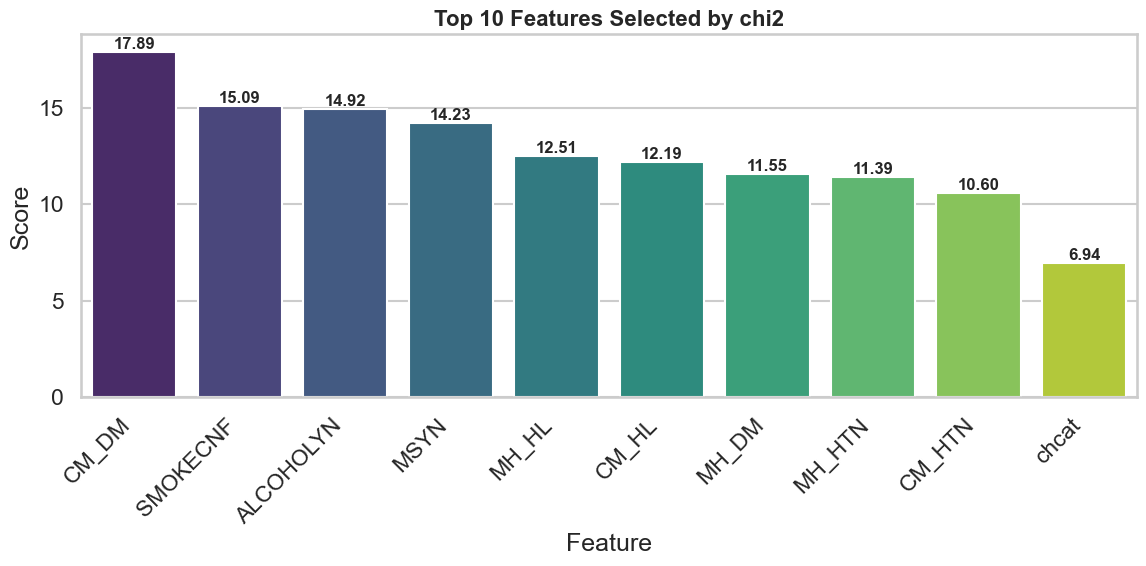

C:\Users\user\AppData\Local\Temp\ipykernel_21460\1473091599.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


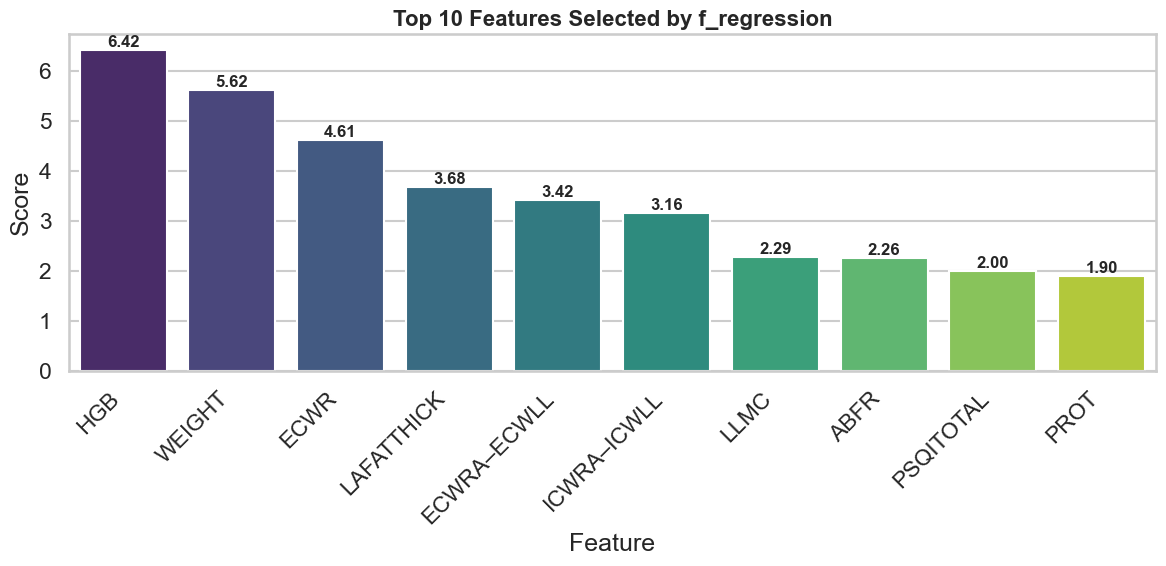

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correct style settings
sns.set_style("whitegrid")
sns.set_context("talk")  # Bigger font for presentation

# Set how many features to plot per method
n_feature = 10  #

# Create top_n dataframe if not already created
scoreboard_top_n_sorted = scoreboard_df_sorted.groupby('Method').head(n_feature)

feature_method = ['chi2', 'f_regression']  

# Loop through selected methods only
for method in feature_method:
    df_plot = scoreboard_top_n_sorted[scoreboard_top_n_sorted['Method'] == method]
    
    if df_plot.empty:
        print(f"Warning: Method '{method}' not found in scoreboard_top_n_sorted. Skipping.")
        continue
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_plot,
        x='Feature',
        y='Score',
        palette='viridis'
    )
    
    # Add scores on top of bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold')
    
    plt.title(f"Top {n_feature} Features Selected by {method}", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Score')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()


 Need adjustment


=== Feature Stability (how many methods selected each feature) ===


Feature
PROT             5
ECWR             5
LAFATTHICK       5
HGB              5
LFNM             4
ABFR             4
ECWRRA–ECWRLL    4
ECWRA–ECWLL      4
ICWRA–ICWLL      4
CHMC             3
PSQITOTAL        3
WEIGHT           3
LLMC             3
BHYDR            3
MSYN             3
CM_HL            3
ECW              2
MH_HTN           2
VFA              2
HRVINDEX         2
Name: Method, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_21460\765649985.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_method_counts.head(20).index, y=feature_method_counts.head(20).values, palette='magma')


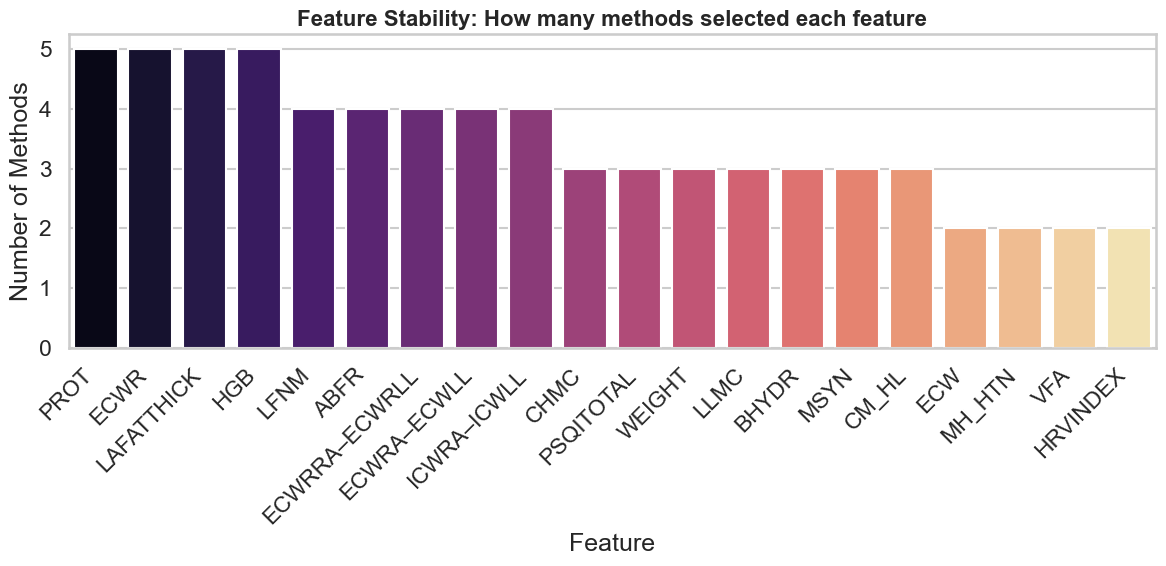


LASSO selected 10 features.
Boruta selected 10 features.
Overlap (features selected by both): 1 features:
{'BMR'}

=== Feature Type Sensitivity (which types of features are selected most) ===


C:\Users\user\AppData\Local\Temp\ipykernel_21460\765649985.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoreboard_top_n_sorted['Feature_Type'] = scoreboard_top_n_sorted['Feature'].apply(get_feature_type)


Feature_Type
Bioimpedance    65
HealthExam      40
HRV             10
Other            5
Name: Feature, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_21460\765649985.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_type_counts.index, y=feature_type_counts.values, palette='pastel')


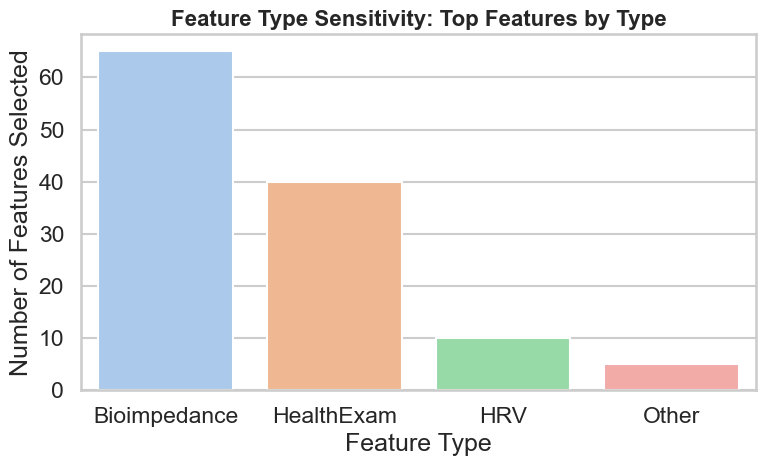


=== Minimal Feature Subset (selected by >= 3 methods) ===
Number of stable features: 16
['PROT', 'ECWR', 'LAFATTHICK', 'HGB', 'LFNM', 'ABFR', 'ECWRRA–ECWRLL', 'ECWRA–ECWLL', 'ICWRA–ICWLL', 'CHMC', 'PSQITOTAL', 'WEIGHT', 'LLMC', 'BHYDR', 'MSYN', 'CM_HL']


In [21]:
# === STEP 3 ANALYSIS TEMPLATE ===

import matplotlib.pyplot as plt
import seaborn as sns

# 1  Feature Stability Analysis
print("\n=== Feature Stability (how many methods selected each feature) ===")
feature_method_counts = scoreboard_top_n_sorted.groupby('Feature')['Method'].nunique().sort_values(ascending=False)
display(feature_method_counts.head(20))

# Optional: Plot feature stability
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_method_counts.head(20).index, y=feature_method_counts.head(20).values, palette='magma')
plt.title("Feature Stability: How many methods selected each feature", fontsize=16, fontweight='bold')
plt.ylabel('Number of Methods')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2  Method Agreement - Overlap Example (LassoCV vs Boruta)
lasso_features = set(scoreboard_top_n_sorted[scoreboard_top_n_sorted['Method'] == 'LassoCV']['Feature'])
boruta_features = set(scoreboard_top_n_sorted[scoreboard_top_n_sorted['Method'] == 'Boruta']['Feature'])

overlap_lasso_boruta = lasso_features.intersection(boruta_features)

print(f"\nLASSO selected {len(lasso_features)} features.")
print(f"Boruta selected {len(boruta_features)} features.")
print(f"Overlap (features selected by both): {len(overlap_lasso_boruta)} features:")
print(overlap_lasso_boruta)

# 3  Top Feature Sources (Bioimpedance / HRV / HealthExam Feature Type Sensitivity)
# This require to have a mapping from feature name → source.


bioimpedance_prefixes = [
    'TBW', 'ICW', 'ECW', 'PROT', 'MINERAL', 'SLM', 'FFM', 'PBF', 'SLRA', 'SWRA',
    'ICWRA', 'ECWRA', 'ECWR', 'ECWRRA', 'FATRA', 'BMR', 'ABFR', 'VFA', 'BCM',
    'BRMC', 'BMC', 'BHYDR', 'FFMI', 'FMI', 'CHMC', 'ABDMC', 'RAMC', 'LAMC',
    'RLMC', 'LLMC', 'CHSTFATTHICK', 'ABDMFATTHICK', 'RAFATTHICK', 'LAFATTHICK',
    'RLFATTHICK', 'LLFATTHICK'
]

hrv_prefixes = [
    'VLF', 'LF', 'HF', 'TP', 'LFNM', 'HFNM', 'HR', 'HRVINDEX', 'SDNN'
]

health_exam_prefixes = [
    'HEIGHT', 'WEIGHT', 'BMI', 'SYSBP', 'DIABP', 'PULSE', 'SMOKECNF', 'ALCOHOLYN',
    'MH_HL', 'MH_HTN', 'MH_DM', 'CM_HL', 'CM_HTN', 'CM_DM', 'cold', 'heat', 'chcat',
    'PSSTOTAL', 'PSQITOTAL', 'CREAT', 'GFRE', 'HGB', 'GLUC', 'AST', 'ALT', 'GGT',
    'WAISTCIR', 'HIPCIR'
]



def get_feature_type(feature):
    for prefix in bioimpedance_prefixes:
        if feature.startswith(prefix):
            return 'Bioimpedance'
    for prefix in hrv_prefixes:
        if feature.startswith(prefix):
            return 'HRV'
    for prefix in health_exam_prefixes:
        if feature.startswith(prefix):
            return 'HealthExam'
    return 'Other'

scoreboard_top_n_sorted['Feature_Type'] = scoreboard_top_n_sorted['Feature'].apply(get_feature_type)

# Count feature types in the top n_feature per method
feature_type_counts = scoreboard_top_n_sorted.groupby('Feature_Type')['Feature'].count().sort_values(ascending=False)

print("\n=== Feature Type Sensitivity (which types of features are selected most) ===")
display(feature_type_counts)

# Optional: Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_type_counts.index, y=feature_type_counts.values, palette='pastel')
plt.title("Feature Type Sensitivity: Top Features by Type", fontsize=16, fontweight='bold')
plt.ylabel('Number of Features Selected')
plt.xlabel('Feature Type')
plt.tight_layout()
plt.show()

# 4 Minimal Feature Subset (stable across multiple methods)
# Define "stable" as selected by at least X methods:
min_method_threshold = 3

stable_features = feature_method_counts[feature_method_counts >= min_method_threshold].index.tolist()

print(f"\n=== Minimal Feature Subset (selected by >= {min_method_threshold} methods) ===")
print(f"Number of stable features: {len(stable_features)}")
print(stable_features)




# Step 4: Regression Modeling (AGE Prediction)

!pip install xgboost

In [ ]:
# Define the feature set want to use
top_n = 10
selected_method = 'LassoCV'  # Example: change to any method 



# Extract features
selected_features = scoreboard_df_sorted[scoreboard_df_sorted['Method'] == selected_method].head(top_n)['Feature'].tolist()


# Show selected features
print(f"Selected features ({selected_method}, top {top_n}):\n{selected_features}")


Selected features (LassoCV, top 10):
['VFA', 'BCM', 'BRMC', 'ECWRRA–ECWRLL', 'FATRA–FATLL', 'BMR', 'ABFR', 'CHMC', 'ABDMC', 'FMI']


In [25]:
# Define X and y
X = final_df[selected_features]  
y = final_df['AGE']

# Optional: scale X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## LinearRegression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

kf = KFold(n_splits=10, shuffle=True, random_state=42)

model = LinearRegression()

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"Linear Regression - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")


Linear Regression - MAE: 9.08, RMSE: 10.66, R2: -0.41


## Ridge

In [28]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"Ridge Regression - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")



Ridge Regression - MAE: 9.06, RMSE: 10.63, R2: -0.40


## LassoCV

In [29]:
from sklearn.linear_model import LassoCV

model = LassoCV(cv=5, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"LassoCV Regression - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")




LassoCV Regression - MAE: 8.39, RMSE: 9.68, R2: -0.15


## RandomForestRegressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"RandomForestRegressor - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")




RandomForestRegressor - MAE: 8.38, RMSE: 9.68, R2: -0.18


## XGBoost

In [31]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"XGBRegressor - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")





XGBRegressor - MAE: 8.84, RMSE: 10.49, R2: -0.42


## SVR

In [32]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"SVR - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")



SVR - MAE: 8.45, RMSE: 9.75, R2: -0.18


## MLP

In [33]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"MLPRegressor - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, R2: {np.mean(r2_scores):.2f}")



MLPRegressor - MAE: 13.12, RMSE: 16.41, R2: -2.40


## All Model

In [ ]:
# Step 4 Modeling Code Template

from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# --- Define Feature Sets ---


# 1 Full Feature Set
X_full = final_df.drop(columns=['AGE', 'USUBJID', 'SITEID'], errors='ignore')
X_full = X_full.select_dtypes(include=[np.number])


# 2 Minimal Feature Subset (Stable Features from Step 3)
X_minimal = final_df[stable_features]
print("Stable Features: ",stable_features)


# 3 Top N Features 
# method selection
top_perm_n = 10
top_perm_features = scoreboard_top_n_sorted[scoreboard_top_n_sorted['Method'] == 'PermutationImportance'].head(top_perm_n)['Feature'].tolist()
X_top_perm = final_df[top_perm_features]

# Target
y = final_df['AGE']




# --- Define Models ---

model_dict = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'LassoCV': LassoCV(cv=5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'SVR': SVR(kernel='rbf'),
    'MLP': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}




# --- Define Feature Sets Dictionary ---

feature_sets = {
    'FullFeatures': X_full,
    'MinimalStableFeatures': X_minimal,
    'TopPermImportance': X_top_perm
}




# --- Standardize Features ---

scaler = StandardScaler()




# --- Define Cross-Validation ---

kf = KFold(n_splits=10, shuffle=True, random_state=42)




# --- Run Modeling and Collect Results ---

results = []

for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    for feature_set_name, X_features in feature_sets.items():
        print(f"  Using feature set: {feature_set_name} ({X_features.shape[1]} features)")
        
        X_scaled = scaler.fit_transform(X_features)
        
        # Cross-validated metrics
        mae_scores = []
        rmse_scores = []
        r2_scores = []
        
        for train_idx, test_idx in kf.split(X_scaled):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            mae_scores.append(mean_absolute_error(y_test, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            r2_scores.append(r2_score(y_test, y_pred))
        
        # Store mean scores
        results.append({
            'Model': model_name,
            'FeatureSet': feature_set_name,
            'MAE': np.mean(mae_scores),
            'RMSE': np.mean(rmse_scores),
            'R2': np.mean(r2_scores)
        })




# --- Results DataFrame ---

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAE')  # Sort by MAE (lower is better)




# --- Display Results ---

print("\n=== Step 4 Model Performance ===")
display(results_df)



Training model: LinearRegression
  Using feature set: FullFeatures (75 features)
  Using feature set: MinimalStableFeatures (16 features)
  Using feature set: TopPermImportance (10 features)

Training model: Ridge
  Using feature set: FullFeatures (75 features)
  Using feature set: MinimalStableFeatures (16 features)
  Using feature set: TopPermImportance (10 features)

Training model: LassoCV
  Using feature set: FullFeatures (75 features)
  Using feature set: MinimalStableFeatures (16 features)
  Using feature set: TopPermImportance (10 features)

Training model: RandomForest
  Using feature set: FullFeatures (75 features)
  Using feature set: MinimalStableFeatures (16 features)
  Using feature set: TopPermImportance (10 features)

Training model: XGBoost
  Using feature set: FullFeatures (75 features)
  Using feature set: MinimalStableFeatures (16 features)
  Using feature set: TopPermImportance (10 features)

Training model: SVR
  Using feature set: FullFeatures (75 features)
  Us

,Model,FeatureSet,MAE,RMSE,R2
10,RandomForest,MinimalStableFeatures,7.534181,8.760312,0.037738
13,XGBoost,MinimalStableFeatures,7.547032,9.224136,-0.077957
4,Ridge,MinimalStableFeatures,7.739449,9.135357,-0.038076
1,LinearRegression,MinimalStableFeatures,7.753946,9.164270,-0.044839
16,SVR,MinimalStableFeatures,8.238595,9.509984,-0.124116
17,SVR,TopPermImportance,8.282159,9.642294,-0.141425
8,LassoCV,TopPermImportance,8.375507,9.643204,-0.146105
7,LassoCV,MinimalStableFeatures,8.411647,9.742084,-0.167970
15,SVR,FullFeatures,8.414429,9.705290,-0.164217
6,LassoCV,FullFeatures,8.415662,9.736479,-0.163561


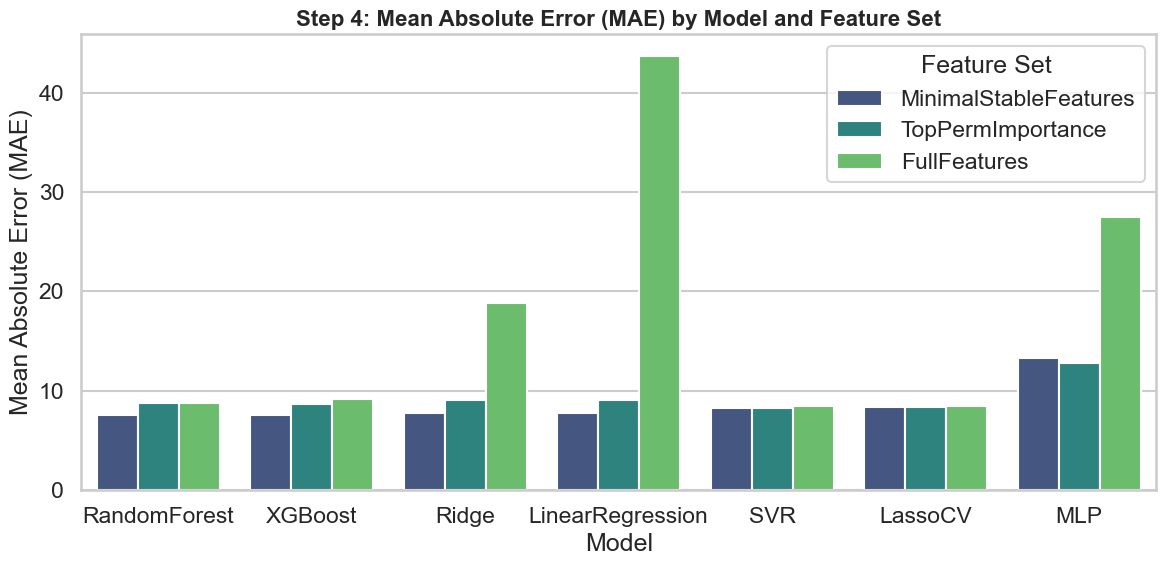

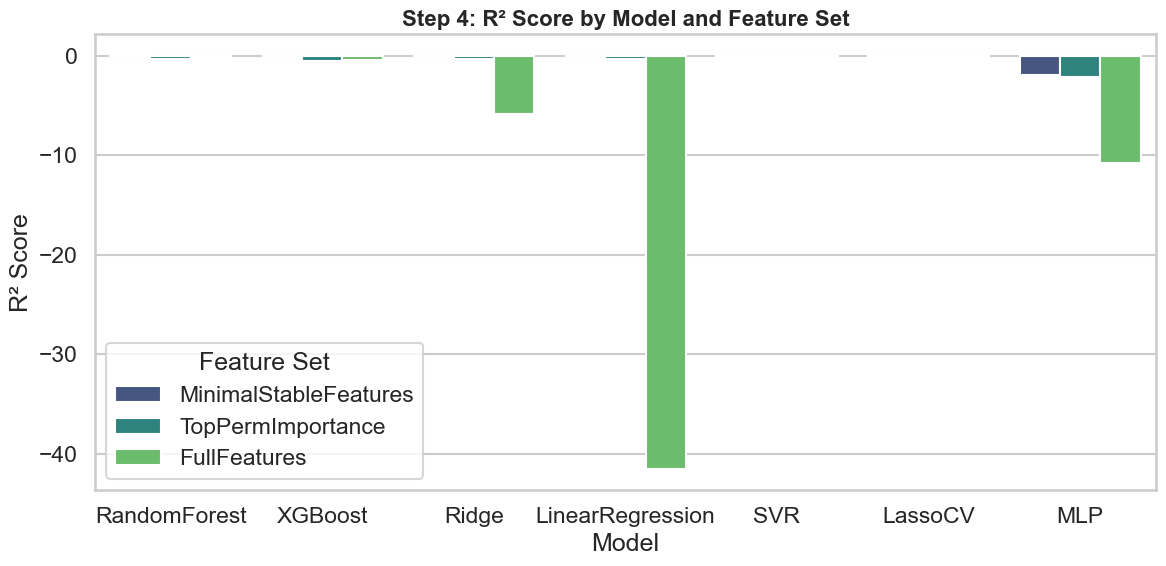

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
sns.set_context("talk")

# --- Plot MAE ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df,
    x='Model',
    y='MAE',
    hue='FeatureSet',
    palette='viridis'
)

plt.title("Step 4: Mean Absolute Error (MAE) by Model and Feature Set", fontsize=16, fontweight='bold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.legend(title='Feature Set')
plt.tight_layout()
plt.show()

# --- Plot R² ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df,
    x='Model',
    y='R2',
    hue='FeatureSet',
    palette='viridis'
)

plt.title("Step 4: R² Score by Model and Feature Set", fontsize=16, fontweight='bold')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.legend(title='Feature Set')
plt.tight_layout()
plt.show()


# Step 5: Explainable AI (XAI)

In [ ]:
!pip install shap
!pip install lime


In [ ]:


import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Important: choose "best model" and feature set from Step 4

# Example — assume RandomForest + MinimalStableFeatures
# can change this:

best_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_best = X_minimal
y_best = y

# Train best model on full data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_best)

best_model.fit(X_scaled, y_best)

# For SHAP & LIME → use non-scaled version:
X_best_orig = X_best.values
feature_names = X_best.columns.tolist()


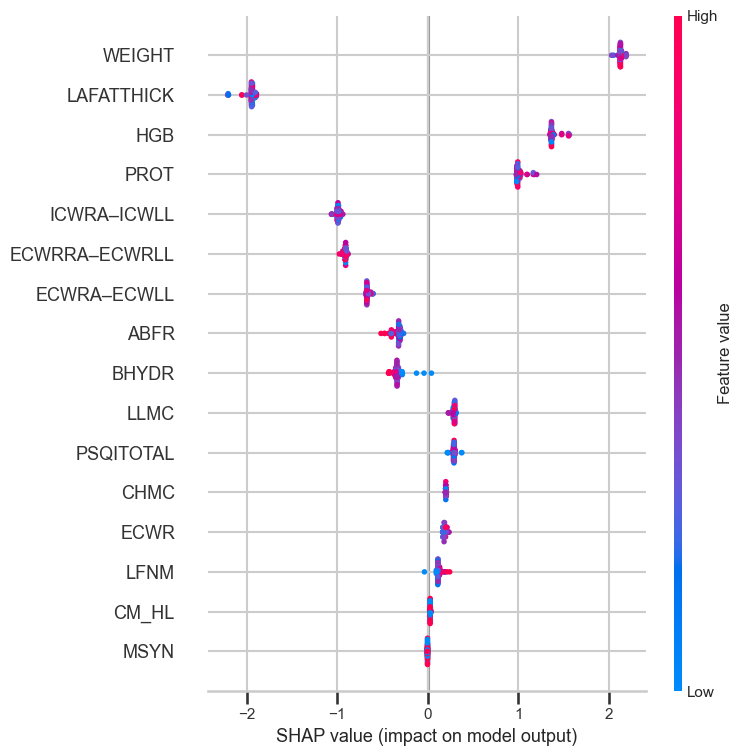

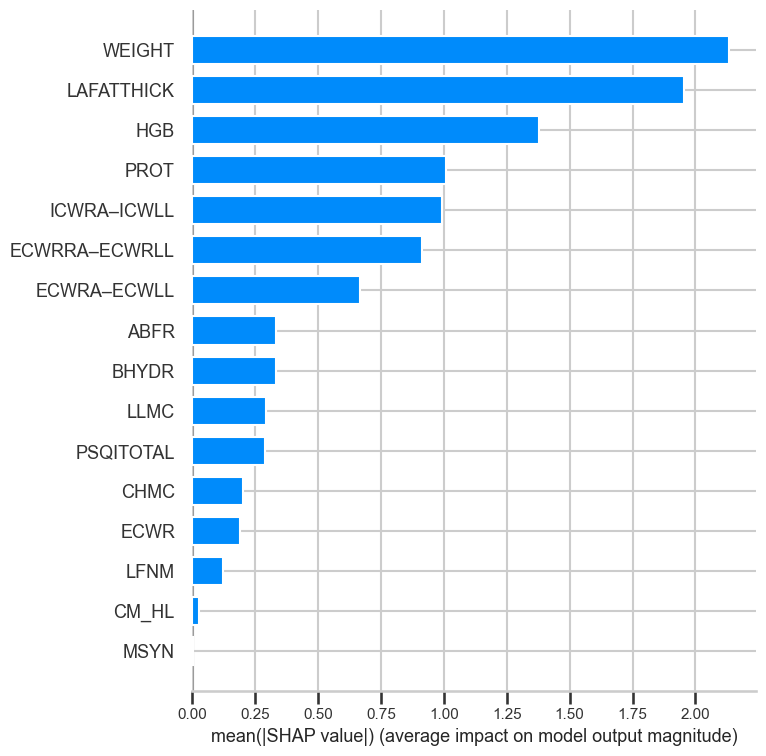

In [36]:
#  SHAP Global Explanation

# Tree-based models → use TreeExplainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_best_orig)

# SHAP Summary Plot (global feature importance)
shap.summary_plot(shap_values, X_best_orig, feature_names=feature_names)

# SHAP Bar Plot
shap.summary_plot(shap_values, X_best_orig, feature_names=feature_names, plot_type='bar')


In [37]:
#  SHAP Local Explanation — Example on 1 sample

# Pick 1 sample — e.g., index 0
sample_idx = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx, :], X_best_orig[sample_idx, :], feature_names=feature_names)


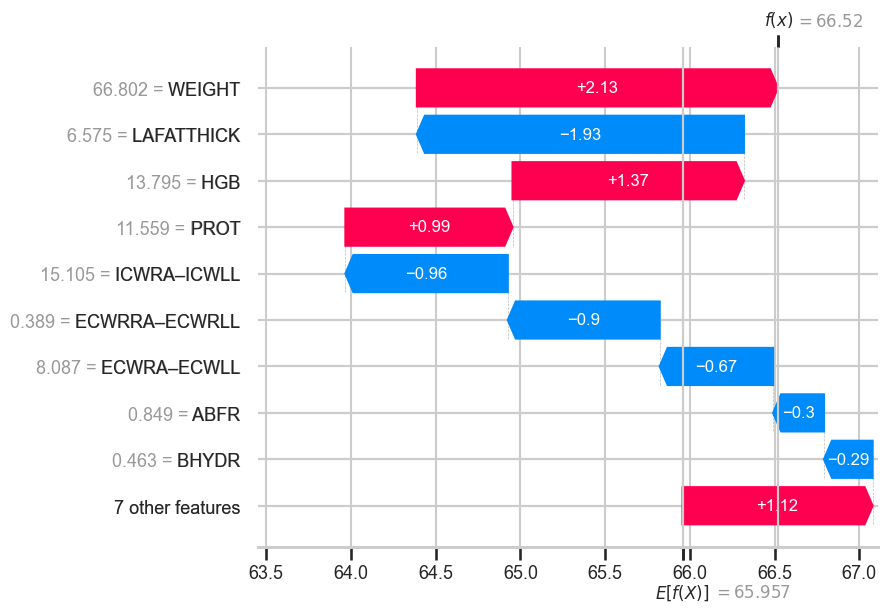

In [38]:
shap.plots.waterfall(shap.Explanation(values=shap_values[sample_idx],
                                      base_values=explainer.expected_value,
                                      data=X_best_orig[sample_idx],
                                      feature_names=feature_names))


In [ ]:
# LIME Local Explanation

from IPython.display import display, HTML

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_best_orig,
    feature_names=feature_names,
    mode='regression'
)

# Explain sample_idx
lime_exp = lime_explainer.explain_instance(X_best_orig[sample_idx], best_model.predict)

# Show explanation
display(HTML(lime_exp.as_html(show_table=True)))
